# Implementing our novel approach with Naive Bayes

> Preprocessing: Clean and preprocess your dataset. This may include handling missing values, encoding categorical variables, and scaling features.

## Load dataset

In [399]:
from libs import data
from libs import kde_lib
import numpy as np
import pandas as pd
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from libs.exp_lib import Density_model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.base import BaseEstimator, ClassifierMixin
from scipy.stats import norm


X0, y0 = data.load_data("banana")

X_train, X_test, y_train, y_test = train_test_split(X0, y0, test_size=0.3, random_state=42)

/Users/biad/Desktop/THESIS/Tests/RKDE_HHO/libs/../data/banana/banana
Loaded banana data: 5300 samples, 2 dimensions, 2 labels
classes = {1.0, -1.0}


In [400]:
""" # Get the dimension of our data
dim = X_train.ndim

# Calculate the number of classes and features
classes = np.unique(y_train)
n_features = X_train.shape[1]

# Initialize robust densities
robust_densities = np.zeros((len(X_train), dim))

print(robust_densities.shape)
kernel = 'gaussian'
#h = .5 """


" # Get the dimension of our data\ndim = X_train.ndim\n\n# Calculate the number of classes and features\nclasses = np.unique(y_train)\nn_features = X_train.shape[1]\n\n# Initialize robust densities\nrobust_densities = np.zeros((len(X_train), dim))\n\nprint(robust_densities.shape)\nkernel = 'gaussian'\n#h = .5 "

## Step2 - step3 : Robust Kernel Density Estimation (RKDE) & Bandwidth Selection using HHO:

- Implement the RKDE algorithm with IRLS and Robust M-estimation (Hampel function) for each class.
- Calculate robust densities for each class based on the RKDE algorithm.


In [401]:

""" for class_label in classes:
    # GET for each class
    class_indices = np.where(y_train==class_label)[0]
    class_X = X_train[class_indices]
    h = kde_lib.hho_bandwith_selection(class_X,class_X)
    #h = .5
    # Get for each feature
    rkde_feature =[]
    for d in range(dim):
        X = class_X[:,d] 
        X = X[:,np.newaxis]
        #print(X.shape)
        model = Density_model("rkde", "banana", 0,kernel,h)
        model.fit(X,X,grid=None)
        rkde = model.density
        
        robust_densities[class_indices,d] = rkde[:,0] """

    


' for class_label in classes:\n    # GET for each class\n    class_indices = np.where(y_train==class_label)[0]\n    class_X = X_train[class_indices]\n    h = kde_lib.hho_bandwith_selection(class_X,class_X)\n    #h = .5\n    # Get for each feature\n    rkde_feature =[]\n    for d in range(dim):\n        X = class_X[:,d] \n        X = X[:,np.newaxis]\n        #print(X.shape)\n        model = Density_model("rkde", "banana", 0,kernel,h)\n        model.fit(X,X,grid=None)\n        rkde = model.density\n        \n        robust_densities[class_indices,d] = rkde[:,0] '

## Step4: Incorporating RKDE into Naive Bayes:

> - Modify Naive Bayes classifier to use the RKDE densities instead of traditional Gaussian densities.
> - For prediction, calculate the likelihood using the robust densities obtained from RKDE.

In [402]:
class RobustNaiveBayes(BaseEstimator, ClassifierMixin):

    def __init__(self) -> None:
        self.class_priors = None
        self.classes = None
        #self.robust_densities = None
        self.kernel = 'gaussian'
        self.classifiers = {}  # Store GaussianNB classifiers for each class
        self.robust_densities = {}  # Store robust densities for each class

    
    def fit(self, X, y):
        """
        Fit the robust Naive Bayes model with RKDE densities.

        Parameters:
        X (array-like): Training data features.
        y (array-like): Training data labels.
        """
        
        n_samples, n_features = X.shape
        self.classes = np.unique(y)
        n_classes = len(self.classes)

        # Calculate class priors
        self.class_priors = np.array([np.mean(y==c) for c in self.classes])

        # Initialize robust densities
        #robust_densities = np.zeros((n_samples, n_features))
        #robust_densities = np.zeros(n_samples)

        for class_label in self.classes :
            # GET for each class
            class_indices = np.where(y==class_label)[0]
            class_data = X[class_indices]

            self.classifiers[class_label] = GaussianNB()
            self.classifiers[class_label].fit(class_data,y[class_indices])
            X_plot = np.linspace(np.min(class_data),np.max(class_data),len(class_data))
            bandwidth = kde_lib.hho_bandwith_selection(class_data,class_data)
            #bandwidth = .955
            model = Density_model("rkde","banana",0,self.kernel,bandwidth)
            model.fit(class_data, class_data, grid=None)
            rkde = model.density 

            self.robust_densities[class_label] = rkde[:,0]
            """ self.robust_densities[class_label] = np.zeros((len(class_data),n_features))
            # Get for each feature
            for feature in range(n_features):
                feature_data = class_data[:,feature]
                feature_data = feature_data[:,np.newaxis]
                #X_plot = np.linspace(np.min(feature_data),np.max(feature_data),len(feature_data))
                #X_plot = X_plot[:,np.newaxis] 
                #bandwidth = kde_lib.hho_bandwith_selection(feature_data,feature_data)
                #print(feature_data.shape)
                #X_plot = X_plot[:,np.newaxis]
                #print(X_plot.shape)
                model = Density_model("rkde","banana",0,self.kernel,bandwidth)
                model.fit(feature_data, feature_data, grid=None)
                rkde = model.density
                #print(robust_densities[class_indices,feature])
                #robust_densities[class_indices,feature] = rkde[:,0]
                self.robust_densities[class_label][:,feature] = rkde[:,0] """
        #self.robust_densities = np.array(robust_densities)
        """ return self._partial_fit(
            X, y, self.classes, _refit=True, sample_weight=sample_weight
        ) """

        

    def predict(self, X):
        """
        Predict class labels and RKDE likelihoods for input data.

        Parameters:
        X (array-like): Input data features.

        Returns:
        y_pred (array-like): Predicted class labels.
        rkde_likelihoods (array-like): RKDE likelihoods for each class.
        """
        n_samples, n_features = X.shape
        n_classes = len(self.classes)
        predictions = []

        """ for sample in X:
            likelihoods = []

            for class_label in self.classes:
                classifier = self.classifiers[class_label]
                robust_density = self.robust_densities[class_label]
                # Calculate the likelihood using the robust density and GaussianNB classifier
                log_likelihood = classifier.predict_joint_log_proba(sample.reshape(1, -1))
                likelihood = np.prod(np.exp(log_likelihood * robust_density)) 
                likelihoods.append(likelihood)

            predicted_class = np.argmax(likelihoods)
            predictions.append(self.classes[predicted_class]) """
        for sample in X:

            likelihoods = []

            # Calculate likelihood for each class
            for class_label in self.classes:
                # GET for each class
                #class_indices = np.where(self.y_train == class_label)[0]
                density = self.robust_densities[class_label]
                likelihoods.append(np.prod(norm.pdf(sample, loc=density.mean(), scale=density.std())))
            
            # Normalize likelihoods using class priors
            normalized_likelihoods = likelihoods * self.class_priors

            # Predict the class with the highest normalized likelihood
            predicted_class = np.argmax(normalized_likelihoods)
            predictions.append(self.classes[predicted_class])
        
        return np.array(predictions)
                


In [403]:
# Create and fit the RobustNaiveBayes classifier
""" classifier = RobustNaiveBayes()
classifier.fit(X_train, y_train)

normal_NB = GaussianNB()
normal_NB.fit(X_train, y_train) """

' classifier = RobustNaiveBayes()\nclassifier.fit(X_train, y_train)\n\nnormal_NB = GaussianNB()\nnormal_NB.fit(X_train, y_train) '

In [404]:
# Check the shape of our train data and the robust densities
print(X_train.shape)
#print(classifier.robust_densities.shape)

(3710, 2)


In [405]:
# Make predictions on the test set
""" y_pred = classifier.predict(X_test)
print(np.unique(y_pred))

normal_NB_pred = normal_NB.predict(X_test)
print(np.unique(normal_NB_pred))

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print("Accuracy 1:", accuracy)
print("precision 1:", precision)
print("recall 1:", recall)
print("f1 1:", f1)

accuracy = accuracy_score(y_test, normal_NB_pred)
precision = precision_score(y_test, normal_NB_pred)
recall = recall_score(y_test, normal_NB_pred)
f1 = f1_score(y_test, normal_NB_pred)
print("Accuracy 2:", accuracy)
print("precision 2:", precision)
print("recall 2:", recall)
print("f1 2:", f1) """


' y_pred = classifier.predict(X_test)\nprint(np.unique(y_pred))\n\nnormal_NB_pred = normal_NB.predict(X_test)\nprint(np.unique(normal_NB_pred))\n\n# Calculate accuracy\naccuracy = accuracy_score(y_test, y_pred)\nprecision = precision_score(y_test, y_pred)\nrecall = recall_score(y_test, y_pred)\nf1 = f1_score(y_test, y_pred)\nprint("Accuracy 1:", accuracy)\nprint("precision 1:", precision)\nprint("recall 1:", recall)\nprint("f1 1:", f1)\n\naccuracy = accuracy_score(y_test, normal_NB_pred)\nprecision = precision_score(y_test, normal_NB_pred)\nrecall = recall_score(y_test, normal_NB_pred)\nf1 = f1_score(y_test, normal_NB_pred)\nprint("Accuracy 2:", accuracy)\nprint("precision 2:", precision)\nprint("recall 2:", recall)\nprint("f1 2:", f1) '

## Classifiers Comparaison 

In [406]:
from sklearn.datasets import make_circles, make_moons, make_classification
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import DecisionBoundaryDisplay


classifiers = {
    "Naive Bayes": GaussianNB(),
    "Robust Naive Bayes": RobustNaiveBayes(),
}
X, y = make_classification(n_features=2, n_redundant=0, n_informative=2, random_state=1, n_clusters_per_class=1)
rng = np.random.RandomState(2)
X += 2 * rng.uniform(size=X.shape)
linearly_separable = (X, y)

datasets = [
    make_moons(noise=0.3, random_state=0),
    make_circles(noise=0.2, factor=0.5, random_state=1),
    linearly_separable,
]
datasets_name = [
    "make_moons",
    "make_circles ",
    "make_classification"
]

figure = plt.figure(figsize=(27, 9))
i = 1

<Figure size 2700x900 with 0 Axes>

2023/08/25 02:26:09 AM, INFO, mealpy.swarm_based.HHO.OriginalHHO: Solving 2-objective optimization problem with weights: [1 1].


Stop at 7 iterations
Stop at 100 iterations
Stop at 7 iterations
Stop at 100 iterations
Stop at 4 iterations
Stop at 100 iterations
Stop at 4 iterations
Stop at 100 iterations
Stop at 3 iterations
Stop at 100 iterations
Stop at 3 iterations
Stop at 100 iterations
Stop at 7 iterations
Stop at 100 iterations
Stop at 7 iterations
Stop at 100 iterations
Stop at 9 iterations
Stop at 100 iterations
Stop at 9 iterations
Stop at 100 iterations
Stop at 9 iterations
Stop at 100 iterations
Stop at 9 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 8 iterations
Stop at 9 iterations
Stop at 8 iterations
Stop at 9 iterations
Stop at 4 iterations
Stop at 100 iterations
Stop at 4 iterations
Stop at 100 iterations
Stop at 7 iterations
Stop at 100 iterations
Stop at 7 iterations
Stop at 100 iterations
Stop at 4 iterations
Stop at 27 iterations
Stop at 4 iterations
Stop at 27 iterations
Stop at 7 iterations
Stop at 100 itera

2023/08/25 02:26:10 AM, INFO, mealpy.swarm_based.HHO.OriginalHHO: >Problem: P, Epoch: 1, Current best: 4.124419757904574, Global best: 4.124419757904574, Runtime: 0.80127 seconds


Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 2 iterations
Stop at 100 iterations
Stop at 2 iterations
Stop at 100 iterations
Stop at 2 iterations
Stop at 100 iterations
Stop at 2 iterations
Stop at 100 iterations
Stop at 8 iterations
Stop at 8 iterations
Stop at 8 iterations
Stop at 8 iterations
Stop at 8 iterations
Stop at 8 iterations
Stop at 8 iterations
Stop at 8 iterations
Stop at 8 iterations
Stop at 8 iterations
Stop at 8 iterations
Stop at 8 iterations
Stop at 7 iterations
Stop at 100 iterations
Stop at 7 iterations
Stop at 100 iterations
Stop at 7 iterations
Stop at 100 iterations
Stop at 7 iterations
Stop at 100 iterations
Stop at 9 iterations
Stop at 100 iterations
Stop at 9 iterations
Stop at 100 iterations
Stop at 9 iterations
Stop at 100 iterations
Stop at 9 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 2 iterations
Stop at 100 iterations
Stop at 2 iterations


2023/08/25 02:26:11 AM, INFO, mealpy.swarm_based.HHO.OriginalHHO: >Problem: P, Epoch: 2, Current best: 4.124419757904574, Global best: 4.124419757904574, Runtime: 0.64597 seconds


Stop at 9 iterations
Stop at 100 iterations
Stop at 2 iterations
Stop at 100 iterations
Stop at 2 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 9 iterations
Stop at 100 iterations
Stop at 9 iterations
Stop at 100 iterations
Stop at 9 iterations
Stop at 100 iterations
Stop at 9 iterations
Stop at 100 iterations
Stop at 4 iterations
Stop at 100 iterations
Stop at 4 iterations
Stop at 100 iterations
Stop at 4 iterations
Stop at 100 iterations
Stop at 4 iterations
Stop at 100 iterations
Stop at 9 iterations
Stop at 100 iterations
Stop at 9 iterations
Stop at 100 iterations
Stop at 9 iterations
Stop at 100 iterations
Stop at 9 iterations
Stop at 100 iterations
Stop at 9 iterations
Stop at 100 iterations
Stop at 9 iterations
Stop at 100 iterations
Stop at 7 iterations
Stop at 100 iterations
Stop at 7 iterations
Stop at 100 iterations
Stop at 9 iterations
Stop at 100 iterations
Stop at 9 iterations
Stop at 100

2023/08/25 02:26:12 AM, INFO, mealpy.swarm_based.HHO.OriginalHHO: >Problem: P, Epoch: 3, Current best: 4.124419757904574, Global best: 4.124419757904574, Runtime: 0.81763 seconds


Stop at 100 iterations
Stop at 9 iterations
Stop at 100 iterations
Stop at 9 iterations
Stop at 100 iterations
Stop at 9 iterations
Stop at 100 iterations
Stop at 9 iterations
Stop at 100 iterations
Stop at 9 iterations
Stop at 100 iterations
Stop at 9 iterations
Stop at 100 iterations
Stop at 8 iterations
Stop at 100 iterations
Stop at 8 iterations
Stop at 100 iterations
Stop at 8 iterations
Stop at 100 iterations
Stop at 8 iterations
Stop at 100 iterations
Stop at 2 iterations
Stop at 100 iterations
Stop at 2 iterations
Stop at 100 iterations
Stop at 9 iterations
Stop at 100 iterations
Stop at 9 iterations
Stop at 100 iterations
Stop at 2 iterations
Stop at 100 iterations
Stop at 2 iterations
Stop at 100 iterations
Stop at 2 iterations
Stop at 100 iterations
Stop at 2 iterations
Stop at 100 iterations
Stop at 9 iterations
Stop at 100 iterations
Stop at 9 iterations
Stop at 100 iterations
Stop at 9 iterations
Stop at 100 iterations
Stop at 9 iterations
Stop at 100 iterations
Stop at 2

2023/08/25 02:26:13 AM, INFO, mealpy.swarm_based.HHO.OriginalHHO: >Problem: P, Epoch: 4, Current best: 4.124419757904574, Global best: 4.124419757904574, Runtime: 0.84420 seconds


Stop at 100 iterations
Stop at 9 iterations
Stop at 100 iterations
Stop at 7 iterations
Stop at 12 iterations
Stop at 7 iterations
Stop at 12 iterations
Stop at 7 iterations
Stop at 12 iterations
Stop at 7 iterations
Stop at 12 iterations
Stop at 9 iterations
Stop at 100 iterations
Stop at 9 iterations
Stop at 100 iterations
Stop at 9 iterations
Stop at 100 iterations
Stop at 9 iterations
Stop at 100 iterations
Stop at 9 iterations
Stop at 100 iterations
Stop at 9 iterations
Stop at 100 iterations
Stop at 9 iterations
Stop at 100 iterations
Stop at 9 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 9 iterations
Stop at 100 iterations
Stop at 9 iterations
Stop at 100 iterations
Stop at 9 iterations
Stop at 100 iterations
Stop at 9 iterations
Stop at 100 iterations
Stop at 8 iterations
Stop at 8 iterations
Stop at 8 itera

2023/08/25 02:26:14 AM, INFO, mealpy.swarm_based.HHO.OriginalHHO: >Problem: P, Epoch: 5, Current best: 4.124419757904574, Global best: 4.124419757904574, Runtime: 1.10698 seconds


Stop at 100 iterations
Stop at 9 iterations
Stop at 100 iterations
Stop at 9 iterations
Stop at 100 iterations
Stop at 9 iterations
Stop at 100 iterations
Stop at 9 iterations
Stop at 100 iterations
Stop at 9 iterations
Stop at 100 iterations
Stop at 9 iterations
Stop at 100 iterations
Stop at 9 iterations
Stop at 100 iterations
Stop at 9 iterations
Stop at 100 iterations
Stop at 9 iterations
Stop at 100 iterations
Stop at 9 iterations
Stop at 100 iterations
Stop at 9 iterations
Stop at 100 iterations
Stop at 9 iterations
Stop at 100 iterations
Stop at 9 iterations
Stop at 100 iterations
Stop at 9 iterations
Stop at 100 iterations
Stop at 9 iterations
Stop at 100 iterations
Stop at 9 iterations
Stop at 100 iterations
Stop at 9 iterations
Stop at 100 iterations
Stop at 9 iterations
Stop at 100 iterations
Stop at 9 iterations
Stop at 100 iterations
Stop at 2 iterations
Stop at 100 iterations
Stop at 2 iterations
Stop at 100 iterations
Stop at 9 iterations
Stop at 100 iterations
Stop at 9

2023/08/25 02:26:15 AM, INFO, mealpy.swarm_based.HHO.OriginalHHO: >Problem: P, Epoch: 6, Current best: 4.124419757904574, Global best: 4.124419757904574, Runtime: 0.92484 seconds


Stop at 100 iterations
Stop at 2 iterations
Stop at 100 iterations
Stop at 2 iterations
Stop at 100 iterations
Stop at 2 iterations
Stop at 100 iterations
Stop at 9 iterations
Stop at 100 iterations
Stop at 9 iterations
Stop at 100 iterations
Stop at 9 iterations
Stop at 100 iterations
Stop at 9 iterations
Stop at 100 iterations
Stop at 9 iterations
Stop at 100 iterations
Stop at 9 iterations
Stop at 100 iterations
Stop at 9 iterations
Stop at 100 iterations
Stop at 9 iterations
Stop at 100 iterations
Stop at 8 iterations
Stop at 100 iterations
Stop at 8 iterations
Stop at 100 iterations
Stop at 8 iterations
Stop at 100 iterations
Stop at 8 iterations
Stop at 100 iterations
Stop at 9 iterations
Stop at 100 iterations
Stop at 9 iterations
Stop at 100 iterations
Stop at 9 iterations
Stop at 100 iterations
Stop at 9 iterations
Stop at 100 iterations
Stop at 9 iterations
Stop at 100 iterations
Stop at 9 iterations
Stop at 100 iterations
Stop at 9 iterations
Stop at 100 iterations
Stop at 9

2023/08/25 02:26:16 AM, INFO, mealpy.swarm_based.HHO.OriginalHHO: >Problem: P, Epoch: 7, Current best: 4.124419757904574, Global best: 4.124419757904574, Runtime: 0.92624 seconds


Stop at 9 iterations
Stop at 100 iterations
Stop at 9 iterations
Stop at 100 iterations
Stop at 9 iterations
Stop at 100 iterations
Stop at 9 iterations
Stop at 100 iterations
Stop at 9 iterations
Stop at 100 iterations
Stop at 9 iterations
Stop at 100 iterations
Stop at 9 iterations
Stop at 100 iterations
Stop at 9 iterations
Stop at 100 iterations
Stop at 9 iterations
Stop at 100 iterations
Stop at 9 iterations
Stop at 100 iterations
Stop at 9 iterations
Stop at 100 iterations
Stop at 9 iterations
Stop at 100 iterations
Stop at 9 iterations
Stop at 100 iterations
Stop at 9 iterations
Stop at 100 iterations
Stop at 9 iterations
Stop at 100 iterations
Stop at 9 iterations
Stop at 100 iterations
Stop at 9 iterations
Stop at 100 iterations
Stop at 9 iterations
Stop at 100 iterations
Stop at 9 iterations
Stop at 100 iterations
Stop at 9 iterations
Stop at 100 iterations
Stop at 9 iterations
Stop at 100 iterations
Stop at 9 iterations
Stop at 100 iterations
Stop at 9 iterations
Stop at 100

2023/08/25 02:26:17 AM, INFO, mealpy.swarm_based.HHO.OriginalHHO: >Problem: P, Epoch: 8, Current best: 4.124419757904574, Global best: 4.124419757904574, Runtime: 1.02489 seconds


Stop at 9 iterations
Stop at 100 iterations
Stop at 9 iterations
Stop at 100 iterations
Stop at 9 iterations
Stop at 100 iterations
Stop at 9 iterations
Stop at 100 iterations
Stop at 9 iterations
Stop at 100 iterations
Stop at 9 iterations
Stop at 100 iterations
Stop at 9 iterations
Stop at 100 iterations
Stop at 9 iterations
Stop at 100 iterations
Stop at 8 iterations
Stop at 100 iterations
Stop at 8 iterations
Stop at 100 iterations
Stop at 8 iterations
Stop at 100 iterations
Stop at 8 iterations
Stop at 100 iterations
Stop at 9 iterations
Stop at 100 iterations
Stop at 9 iterations
Stop at 100 iterations
Stop at 9 iterations
Stop at 100 iterations
Stop at 9 iterations
Stop at 100 iterations
Stop at 9 iterations
Stop at 100 iterations
Stop at 9 iterations
Stop at 100 iterations
Stop at 9 iterations
Stop at 100 iterations
Stop at 9 iterations
Stop at 100 iterations
Stop at 9 iterations
Stop at 100 iterations
Stop at 9 iterations
Stop at 100 iterations
Stop at 9 iterations
Stop at 100

2023/08/25 02:26:18 AM, INFO, mealpy.swarm_based.HHO.OriginalHHO: >Problem: P, Epoch: 9, Current best: 4.124419757904574, Global best: 4.124419757904574, Runtime: 1.02621 seconds


Stop at 100 iterations
Stop at 9 iterations
Stop at 100 iterations
Stop at 9 iterations
Stop at 100 iterations
Stop at 9 iterations
Stop at 100 iterations
Stop at 9 iterations
Stop at 100 iterations
Stop at 9 iterations
Stop at 100 iterations
Stop at 9 iterations
Stop at 100 iterations
Stop at 9 iterations
Stop at 100 iterations
Stop at 9 iterations
Stop at 100 iterations
Stop at 9 iterations
Stop at 100 iterations
Stop at 9 iterations
Stop at 100 iterations
Stop at 9 iterations
Stop at 100 iterations
Stop at 9 iterations
Stop at 100 iterations
Stop at 9 iterations
Stop at 100 iterations
Stop at 9 iterations
Stop at 100 iterations
Stop at 9 iterations
Stop at 100 iterations
Stop at 9 iterations
Stop at 100 iterations
Stop at 9 iterations
Stop at 100 iterations
Stop at 9 iterations
Stop at 100 iterations
Stop at 9 iterations
Stop at 100 iterations
Stop at 9 iterations
Stop at 100 iterations
Stop at 9 iterations
Stop at 100 iterations
Stop at 9 iterations
Stop at 100 iterations
Stop at 9

2023/08/25 02:26:19 AM, INFO, mealpy.swarm_based.HHO.OriginalHHO: >Problem: P, Epoch: 10, Current best: 4.124419757904574, Global best: 4.124419757904574, Runtime: 1.13322 seconds
2023/08/25 02:26:19 AM, INFO, mealpy.swarm_based.HHO.OriginalHHO: Solving 2-objective optimization problem with weights: [1 1].


Stop at 100 iterations
Stop at 9 iterations
Stop at 100 iterations
Stop at 9 iterations
Stop at 100 iterations
Stop at 9 iterations
Stop at 100 iterations
Stop at 9 iterations
Stop at 100 iterations
Stop at 9 iterations
Stop at 100 iterations
Stop at 9 iterations
Stop at 100 iterations
Result hho_bandwith_selection: [0.9]
Stop at 9 iterations
Stop at 100 iterations
Stop at 7 iterations
Stop at 24 iterations
Stop at 7 iterations
Stop at 24 iterations
Stop at 3 iterations
Stop at 52 iterations
Stop at 3 iterations
Stop at 52 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 7 iterations
Stop at 29 iterations
Stop at 7 iterations
Stop at 29 iterations
Stop at 6 iterations
Stop at 33 iterations
Stop at 6 iterations
Stop at 33 iterations
Stop at 3 iterations
Stop at 100 iterations
Stop at 3 iterations
Stop at 100 iterations
Stop at 7 iterations
Stop at 100 iterations
Stop at 7 iterations
Stop at 100 iterations
Stop at 8 iterations
Sto

2023/08/25 02:26:20 AM, INFO, mealpy.swarm_based.HHO.OriginalHHO: >Problem: P, Epoch: 1, Current best: 5.628604919827249, Global best: 5.628604919827249, Runtime: 0.50130 seconds


Stop at 100 iterations
Stop at 3 iterations
Stop at 100 iterations
Stop at 3 iterations
Stop at 100 iterations
Stop at 8 iterations
Stop at 31 iterations
Stop at 8 iterations
Stop at 31 iterations
Stop at 8 iterations
Stop at 31 iterations
Stop at 8 iterations
Stop at 31 iterations
Stop at 3 iterations
Stop at 100 iterations
Stop at 3 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 9 iterations
Stop at 5 iterations
Stop at 9 iterations
Stop at 8 iterations
Stop at 31 iterations
Stop at 8 iterations
Stop at 31 iterations
Stop at 8 iterations
Stop at 31 iterations
Stop at 8 iterations
Stop at 31 iterations
Stop at 8 iterations
Stop at 31 iterations
Stop at 8 iterations
Stop at 31 iterations
Stop at 8 iterations
Stop at 31 iterations
Stop at 8 iterations
Stop at 31 iterations
Stop at 6 iterations
Stop at 33 iterations
Stop at 6 iterations
Stop at 33 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 3 iterations
Stop a

2023/08/25 02:26:20 AM, INFO, mealpy.swarm_based.HHO.OriginalHHO: >Problem: P, Epoch: 2, Current best: 5.628604919827249, Global best: 5.628604919827249, Runtime: 0.44913 seconds


Stop at 31 iterations
Stop at 7 iterations
Stop at 25 iterations
Stop at 7 iterations
Stop at 25 iterations
Stop at 7 iterations
Stop at 100 iterations
Stop at 7 iterations
Stop at 100 iterations
Stop at 4 iterations
Stop at 9 iterations
Stop at 4 iterations
Stop at 9 iterations
Stop at 7 iterations
Stop at 24 iterations
Stop at 7 iterations
Stop at 24 iterations
Stop at 3 iterations
Stop at 100 iterations
Stop at 3 iterations
Stop at 100 iterations
Stop at 8 iterations
Stop at 29 iterations
Stop at 8 iterations
Stop at 29 iterations
Stop at 8 iterations
Stop at 31 iterations
Stop at 8 iterations
Stop at 31 iterations
Stop at 8 iterations
Stop at 31 iterations
Stop at 8 iterations
Stop at 31 iterations
Stop at 7 iterations
Stop at 26 iterations
Stop at 7 iterations
Stop at 26 iterations
Stop at 7 iterations
Stop at 26 iterations
Stop at 7 iterations
Stop at 26 iterations
Stop at 3 iterations
Stop at 100 iterations
Stop at 3 iterations
Stop at 100 iterations
Stop at 8 iterations
Stop at

2023/08/25 02:26:21 AM, INFO, mealpy.swarm_based.HHO.OriginalHHO: >Problem: P, Epoch: 3, Current best: 5.628604919827249, Global best: 5.628604919827249, Runtime: 0.42534 seconds


Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 3 iterations
Stop at 100 iterations
Stop at 3 iterations
Stop at 100 iterations
Stop at 8 iterations
Stop at 31 iterations
Stop at 8 iterations
Stop at 31 iterations
Stop at 3 iterations
Stop at 100 iterations
Stop at 3 iterations
Stop at 100 iterations
Stop at 7 iterations
Stop at 29 iterations
Stop at 7 iterations
Stop at 29 iterations
Stop at 7 iterations
Stop at 29 iterations
Stop at 7 iterations
Stop at 29 iterations
Stop at 8 iterations
Stop at 31 iterations
Stop at 8 iterations
Stop at 31 iterations
Stop at 8 iterations
Stop at 31 iterations
Stop at 8 iterations
Stop at 31 iterations
Stop at 8 iterations
Stop at 31 iterations
Stop at 8 iterations
Stop at 31 iterations
Stop at 8 iterations
Stop at 31 iterations
Stop at 8 iterations
Stop at 31 iterations
Stop at 8 iterations
Stop at 31 iterations
Stop at 8 iterations
Stop at 31 iterations
Stop at 8 iterations
Stop at 31 iterations
Stop at 8 iterations
Stop 

2023/08/25 02:26:21 AM, INFO, mealpy.swarm_based.HHO.OriginalHHO: >Problem: P, Epoch: 4, Current best: 5.628604919827249, Global best: 5.628604919827249, Runtime: 0.47088 seconds


Stop at 7 iterations
Stop at 31 iterations
Stop at 8 iterations
Stop at 31 iterations
Stop at 8 iterations
Stop at 31 iterations
Stop at 4 iterations
Stop at 100 iterations
Stop at 4 iterations
Stop at 100 iterations
Stop at 8 iterations
Stop at 31 iterations
Stop at 8 iterations
Stop at 31 iterations
Stop at 8 iterations
Stop at 31 iterations
Stop at 8 iterations
Stop at 31 iterations
Stop at 3 iterations
Stop at 100 iterations
Stop at 3 iterations
Stop at 100 iterations
Stop at 8 iterations
Stop at 31 iterations
Stop at 8 iterations
Stop at 31 iterations
Stop at 8 iterations
Stop at 31 iterations
Stop at 8 iterations
Stop at 31 iterations
Stop at 3 iterations
Stop at 19 iterations
Stop at 3 iterations
Stop at 19 iterations
Stop at 3 iterations
Stop at 100 iterations
Stop at 3 iterations
Stop at 100 iterations
Stop at 3 iterations
Stop at 100 iterations
Stop at 3 iterations
Stop at 100 iterations
Stop at 3 iterations
Stop at 100 iterations
Stop at 3 iterations
Stop at 100 iterations
S

2023/08/25 02:26:22 AM, INFO, mealpy.swarm_based.HHO.OriginalHHO: >Problem: P, Epoch: 5, Current best: 5.628604919827249, Global best: 5.628604919827249, Runtime: 0.49426 seconds


Stop at 100 iterations
Stop at 3 iterations
Stop at 100 iterations
Stop at 8 iterations
Stop at 31 iterations
Stop at 8 iterations
Stop at 31 iterations
Stop at 8 iterations
Stop at 31 iterations
Stop at 8 iterations
Stop at 31 iterations
Stop at 8 iterations
Stop at 31 iterations
Stop at 8 iterations
Stop at 31 iterations
Stop at 8 iterations
Stop at 31 iterations
Stop at 8 iterations
Stop at 31 iterations
Stop at 8 iterations
Stop at 31 iterations
Stop at 8 iterations
Stop at 31 iterations
Stop at 8 iterations
Stop at 31 iterations
Stop at 8 iterations
Stop at 31 iterations
Stop at 4 iterations
Stop at 100 iterations
Stop at 4 iterations
Stop at 100 iterations
Stop at 3 iterations
Stop at 100 iterations
Stop at 3 iterations
Stop at 100 iterations
Stop at 4 iterations
Stop at 100 iterations
Stop at 4 iterations
Stop at 100 iterations
Stop at 8 iterations
Stop at 31 iterations
Stop at 8 iterations
Stop at 31 iterations
Stop at 8 iterations
Stop at 31 iterations
Stop at 8 iterations
Sto

2023/08/25 02:26:22 AM, INFO, mealpy.swarm_based.HHO.OriginalHHO: >Problem: P, Epoch: 6, Current best: 5.628604919827249, Global best: 5.628604919827249, Runtime: 0.44222 seconds


Stop at 8 iterations
Stop at 31 iterations
Stop at 8 iterations
Stop at 31 iterations
Stop at 8 iterations
Stop at 31 iterations
Stop at 8 iterations
Stop at 29 iterations
Stop at 8 iterations
Stop at 29 iterations
Stop at 8 iterations
Stop at 31 iterations
Stop at 8 iterations
Stop at 31 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 8 iterations
Stop at 29 iterations
Stop at 8 iterations
Stop at 29 iterations
Stop at 8 iterations
Stop at 29 iterations
Stop at 8 iterations
Stop at 29 iterations
Stop at 8 iterations
Stop at 31 iterations
Stop at 8 iterations
Stop at 31 iterations
Stop at 8 iterations
Stop at 31 iterations
Stop at 8 iterations
Stop at 31 iterations
Stop at 8 iterations
Stop at 31 iterations
Stop at 8 iterations
Stop at 31 iterations
Stop at 8 iterations
Stop at 31 iterations
Stop at 8 iterations
Stop at 31 iterations
Stop at

2023/08/25 02:26:23 AM, INFO, mealpy.swarm_based.HHO.OriginalHHO: >Problem: P, Epoch: 7, Current best: 5.628604919827249, Global best: 5.628604919827249, Runtime: 0.43321 seconds


Stop at 100 iterations
Stop at 3 iterations
Stop at 100 iterations
Stop at 8 iterations
Stop at 31 iterations
Stop at 8 iterations
Stop at 31 iterations
Stop at 8 iterations
Stop at 31 iterations
Stop at 8 iterations
Stop at 31 iterations
Stop at 7 iterations
Stop at 28 iterations
Stop at 7 iterations
Stop at 28 iterations
Stop at 7 iterations
Stop at 28 iterations
Stop at 7 iterations
Stop at 28 iterations
Stop at 8 iterations
Stop at 31 iterations
Stop at 8 iterations
Stop at 31 iterations
Stop at 8 iterations
Stop at 31 iterations
Stop at 8 iterations
Stop at 31 iterations
Stop at 8 iterations
Stop at 29 iterations
Stop at 8 iterations
Stop at 29 iterations
Stop at 8 iterations
Stop at 29 iterations
Stop at 8 iterations
Stop at 29 iterations
Stop at 8 iterations
Stop at 29 iterations
Stop at 8 iterations
Stop at 29 iterations
Stop at 8 iterations
Stop at 31 iterations
Stop at 8 iterations
Stop at 31 iterations
Stop at 7 iterations
Stop at 28 iterations
Stop at 7 iterations
Stop at 2

2023/08/25 02:26:23 AM, INFO, mealpy.swarm_based.HHO.OriginalHHO: >Problem: P, Epoch: 8, Current best: 5.628604919827249, Global best: 5.628604919827249, Runtime: 0.42062 seconds


Stop at 31 iterations
Stop at 8 iterations
Stop at 31 iterations
Stop at 8 iterations
Stop at 31 iterations
Stop at 7 iterations
Stop at 25 iterations
Stop at 7 iterations
Stop at 25 iterations
Stop at 7 iterations
Stop at 26 iterations
Stop at 7 iterations
Stop at 26 iterations
Stop at 7 iterations
Stop at 32 iterations
Stop at 7 iterations
Stop at 32 iterations
Stop at 7 iterations
Stop at 31 iterations
Stop at 7 iterations
Stop at 31 iterations
Stop at 8 iterations
Stop at 31 iterations
Stop at 8 iterations
Stop at 31 iterations
Stop at 8 iterations
Stop at 31 iterations
Stop at 8 iterations
Stop at 31 iterations
Stop at 7 iterations
Stop at 25 iterations
Stop at 7 iterations
Stop at 25 iterations
Stop at 7 iterations
Stop at 25 iterations
Stop at 7 iterations
Stop at 25 iterations
Stop at 8 iterations
Stop at 31 iterations
Stop at 8 iterations
Stop at 31 iterations
Stop at 8 iterations
Stop at 31 iterations
Stop at 8 iterations
Stop at 31 iterations


2023/08/25 02:26:23 AM, INFO, mealpy.swarm_based.HHO.OriginalHHO: >Problem: P, Epoch: 9, Current best: 5.628604919827249, Global best: 5.628604919827249, Runtime: 0.34711 seconds


Stop at 8 iterations
Stop at 31 iterations
Stop at 8 iterations
Stop at 31 iterations
Stop at 8 iterations
Stop at 31 iterations
Stop at 8 iterations
Stop at 31 iterations
Stop at 8 iterations
Stop at 31 iterations
Stop at 8 iterations
Stop at 31 iterations
Stop at 8 iterations
Stop at 31 iterations
Stop at 8 iterations
Stop at 31 iterations
Stop at 8 iterations
Stop at 31 iterations
Stop at 8 iterations
Stop at 31 iterations
Stop at 8 iterations
Stop at 31 iterations
Stop at 8 iterations
Stop at 31 iterations
Stop at 8 iterations
Stop at 31 iterations
Stop at 8 iterations
Stop at 31 iterations
Stop at 8 iterations
Stop at 31 iterations
Stop at 8 iterations
Stop at 31 iterations
Stop at 8 iterations
Stop at 31 iterations
Stop at 8 iterations
Stop at 31 iterations
Stop at 8 iterations
Stop at 31 iterations
Stop at 8 iterations
Stop at 31 iterations
Stop at 8 iterations
Stop at 31 iterations
Stop at 8 iterations
Stop at 31 iterations
Stop at 8 iterations
Stop at 31 iterations
Stop at 8 i

2023/08/25 02:26:24 AM, INFO, mealpy.swarm_based.HHO.OriginalHHO: >Problem: P, Epoch: 10, Current best: 5.628604919827249, Global best: 5.628604919827249, Runtime: 0.31344 seconds


Stop at 31 iterations
Stop at 8 iterations
Stop at 31 iterations
Stop at 8 iterations
Stop at 31 iterations
Stop at 8 iterations
Stop at 31 iterations
Result hho_bandwith_selection: [0.9]
Stop at 8 iterations
Stop at 31 iterations


2023/08/25 02:27:09 AM, INFO, mealpy.swarm_based.HHO.OriginalHHO: Solving 2-objective optimization problem with weights: [1 1].


Stop at 3 iterations
Stop at 100 iterations
Stop at 3 iterations
Stop at 100 iterations
Stop at 3 iterations
Stop at 61 iterations
Stop at 3 iterations
Stop at 61 iterations
Stop at 4 iterations
Stop at 100 iterations
Stop at 4 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 3 iterations
Stop at 100 iterations
Stop at 3 iterations
Stop at 100 iterations
Stop at 4 iterations
Stop at 100 iterations
Stop at 4 iterations
Stop at 100 iterations
Stop at 3 iterations
Stop at 100 iterations
Stop at 3 iterations
Stop at 100 iterations
Stop at 4 iterations
Stop at 100 iterations
Stop at 4 iterations
Stop at 100 iterations
Stop at 4 iterations
Stop at 100 iterations
Stop at 4 iterations
Stop at 100 iterations
Stop at 2 iterations
Stop at 21 iterations
Stop at 2 iterations
Stop at 21 iterations
Stop at 3 iterations
Stop at 100 iterations
Stop at 3 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 ite

2023/08/25 02:27:10 AM, INFO, mealpy.swarm_based.HHO.OriginalHHO: >Problem: P, Epoch: 1, Current best: 3.2479511663473253, Global best: 3.2479511663473253, Runtime: 0.71008 seconds


Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 3 iterations
Stop at 100 iterations
Stop at 3 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 2 iterations
Stop at 5 iterations
Stop at 2 iterations
Stop at 5 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 2 iterations
Stop at 4 iterations
Stop at 2 iterations
Stop at 4 iterations
Stop at 5 iterations
Stop at 100 iterations


2023/08/25 02:27:10 AM, INFO, mealpy.swarm_based.HHO.OriginalHHO: >Problem: P, Epoch: 2, Current best: 3.2479511663473253, Global best: 3.2479511663473253, Runtime: 0.50160 seconds


Stop at 5 iterations
Stop at 100 iterations
Stop at 3 iterations
Stop at 100 iterations
Stop at 3 iterations
Stop at 100 iterations
Stop at 2 iterations
Stop at 100 iterations
Stop at 2 iterations
Stop at 100 iterations
Stop at 2 iterations
Stop at 5 iterations
Stop at 2 iterations
Stop at 5 iterations
Stop at 3 iterations
Stop at 44 iterations
Stop at 3 iterations
Stop at 44 iterations
Stop at 2 iterations
Stop at 5 iterations
Stop at 2 iterations
Stop at 5 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 2 iterations
Stop at 29 iterations
Stop at 2 iterations
Stop at 29 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations


2023/08/25 02:27:11 AM, INFO, mealpy.swarm_based.HHO.OriginalHHO: >Problem: P, Epoch: 3, Current best: 3.2479511663473253, Global best: 3.2479511663473253, Runtime: 0.67146 seconds


Stop at 100 iterations
Stop at 3 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 3 iterations
Stop at 100 iterations
Stop at 3 iterations
Stop at 100 iterations
Stop at 3 iterations
Stop at 100 iterations
Stop at 3 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 2 iterations
Stop at 5 iterations
Stop at 2 iterations
Stop at 5 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 2 iterations
Stop at 5 iterations
Stop at 2 iterations
Stop at 5 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterati

2023/08/25 02:27:12 AM, INFO, mealpy.swarm_based.HHO.OriginalHHO: >Problem: P, Epoch: 4, Current best: 3.2479511663473253, Global best: 3.2479511663473253, Runtime: 0.62987 seconds


Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 4 iterations
Stop at 100 iterations
Stop at 4 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 3 iterations
Stop at 100 iterations
Stop at 3 iterations
Stop at 100 iterations
Stop at 3 iterations
Stop at 66 iterations
Stop at 3 iterations
Stop at 66 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 i

2023/08/25 02:27:13 AM, INFO, mealpy.swarm_based.HHO.OriginalHHO: >Problem: P, Epoch: 5, Current best: 3.2479511663473253, Global best: 3.2479511663473253, Runtime: 0.91972 seconds


Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 3 iterations
Stop at 65 iterations
Stop at 3 iterations
Stop at 65 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 3 iterations
Stop at 100 iterations
Stop at 3 iterations
Stop at 100 iterations
Stop at 3 iterations
Stop at 100 iterations
Stop at 3 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 4 iterations
Stop at 100 iterations
Stop at 4 iterations
Stop at 100 iterations
Stop at 4 iterations
Stop at 100 iterations
Stop at 4 i

2023/08/25 02:27:14 AM, INFO, mealpy.swarm_based.HHO.OriginalHHO: >Problem: P, Epoch: 6, Current best: 3.2479511663473253, Global best: 3.2479511663473253, Runtime: 1.26760 seconds


Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 4 iterations
Stop at 100 iterations
Stop at 4 iterations
Stop at 100 iterations
Stop at 4 iterations
Stop at 100 iterations
Stop at 4 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100

2023/08/25 02:27:15 AM, INFO, mealpy.swarm_based.HHO.OriginalHHO: >Problem: P, Epoch: 7, Current best: 3.2479511663473253, Global best: 3.2479511663473253, Runtime: 0.91444 seconds


Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 4 iterations
Stop at 100 iterations
Stop at 4 iterations
Stop at 100 iterations
Stop at 4 iterations
Stop at 100 iterations
Stop at 4 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100

2023/08/25 02:27:16 AM, INFO, mealpy.swarm_based.HHO.OriginalHHO: >Problem: P, Epoch: 8, Current best: 3.2479511663473253, Global best: 3.2479511663473253, Runtime: 1.12123 seconds


Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5

2023/08/25 02:27:17 AM, INFO, mealpy.swarm_based.HHO.OriginalHHO: >Problem: P, Epoch: 9, Current best: 3.2479511663473253, Global best: 3.2479511663473253, Runtime: 1.15493 seconds


Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5

2023/08/25 02:27:18 AM, INFO, mealpy.swarm_based.HHO.OriginalHHO: >Problem: P, Epoch: 10, Current best: 3.2479511663473253, Global best: 3.2479511663473253, Runtime: 1.09716 seconds
2023/08/25 02:27:18 AM, INFO, mealpy.swarm_based.HHO.OriginalHHO: Solving 2-objective optimization problem with weights: [1 1].


Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Result hho_bandwith_selection: [0.9]
Stop at 5 iterations
Stop at 100 iterations
Stop at 7 iterations
Stop at 26 iterations
Stop at 7 iterations
Stop at 26 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 4 iterations
Stop at 100 iterations
Stop at 4 iterations
Stop at 100 iterations
Stop at 7 iterations
Stop at 30 iterations
Stop at 7 iterations
Stop at 30 iterations
Stop at 7 iterations
Stop at 30 iterations
Stop at 7 iterations
Stop at 30 iterations
Stop at 7 iterations
Stop at 30 iterations
Stop at 7 iterations
Stop at 30 iterations
Stop at 7 iterations
Stop at 26 iterations
Stop at 7 iterations
Stop at 26 iterations
Stop at 7 iterations
Stop at 30 iterations
Stop at 7 iterations
Stop at 30 iterations
Stop at 7 iterations
Stop at 30 iterations
Stop at 7 iterations
Stop at 

2023/08/25 02:27:19 AM, INFO, mealpy.swarm_based.HHO.OriginalHHO: >Problem: P, Epoch: 1, Current best: 12.225308787725643, Global best: 12.225308787725643, Runtime: 0.33939 seconds


Stop at 100 iterations
Stop at 7 iterations
Stop at 32 iterations
Stop at 7 iterations
Stop at 32 iterations
Stop at 6 iterations
Stop at 26 iterations
Stop at 6 iterations
Stop at 26 iterations
Stop at 7 iterations
Stop at 30 iterations
Stop at 7 iterations
Stop at 30 iterations
Stop at 3 iterations
Stop at 77 iterations
Stop at 3 iterations
Stop at 77 iterations
Stop at 7 iterations
Stop at 26 iterations
Stop at 7 iterations
Stop at 26 iterations
Stop at 7 iterations
Stop at 30 iterations
Stop at 7 iterations
Stop at 30 iterations
Stop at 7 iterations
Stop at 100 iterations
Stop at 7 iterations
Stop at 100 iterations
Stop at 3 iterations
Stop at 77 iterations
Stop at 3 iterations
Stop at 77 iterations
Stop at 7 iterations
Stop at 26 iterations
Stop at 7 iterations
Stop at 26 iterations
Stop at 7 iterations
Stop at 30 iterations
Stop at 7 iterations
Stop at 30 iterations
Stop at 7 iterations
Stop at 26 iterations
Stop at 7 iterations
Stop at 26 iterations
Stop at 3 iterations
Stop at 

2023/08/25 02:27:19 AM, INFO, mealpy.swarm_based.HHO.OriginalHHO: >Problem: P, Epoch: 2, Current best: 11.134310641115212, Global best: 11.134310641115212, Runtime: 0.48254 seconds


Stop at 3 iterations
Stop at 77 iterations
Stop at 3 iterations
Stop at 77 iterations
Stop at 3 iterations
Stop at 100 iterations
Stop at 3 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 7 iterations
Stop at 30 iterations
Stop at 7 iterations
Stop at 30 iterations
Stop at 7 iterations
Stop at 30 iterations
Stop at 7 iterations
Stop at 30 iterations
Stop at 3 iterations
Stop at 77 iterations
Stop at 3 iterations
Stop at 77 iterations
Stop at 7 iterations
Stop at 30 iterations
Stop at 7 iterations
Stop at 30 iterations
Stop at 6 iterations
Stop at 26 iterations
Stop at 6 iterations
Stop at 26 iterations
Stop at 3 iterations
Stop at 77 iterations
Stop at 3 iterations
Stop at 77 iterations
Stop at 7 iterations
Stop at 30 iterations
Stop at 7 iterations
Stop at 30 iterations
Stop at 3 iterations
Stop at 77 iterations
Stop at 3 iterations
Stop at 77 iterations
Stop at 3 iterations
Stop at 77 iterations
Stop at

2023/08/25 02:27:20 AM, INFO, mealpy.swarm_based.HHO.OriginalHHO: >Problem: P, Epoch: 3, Current best: 11.134310641115212, Global best: 11.134310641115212, Runtime: 0.53576 seconds


Stop at 77 iterations
Stop at 3 iterations
Stop at 77 iterations
Stop at 3 iterations
Stop at 77 iterations
Stop at 3 iterations
Stop at 77 iterations
Stop at 7 iterations
Stop at 26 iterations
Stop at 7 iterations
Stop at 26 iterations
Stop at 3 iterations
Stop at 30 iterations
Stop at 3 iterations
Stop at 30 iterations
Stop at 3 iterations
Stop at 30 iterations
Stop at 3 iterations
Stop at 30 iterations
Stop at 7 iterations
Stop at 30 iterations
Stop at 7 iterations
Stop at 30 iterations
Stop at 7 iterations
Stop at 30 iterations
Stop at 7 iterations
Stop at 30 iterations
Stop at 7 iterations
Stop at 100 iterations
Stop at 7 iterations
Stop at 100 iterations
Stop at 7 iterations
Stop at 100 iterations
Stop at 7 iterations
Stop at 100 iterations
Stop at 7 iterations
Stop at 100 iterations
Stop at 7 iterations
Stop at 100 iterations
Stop at 7 iterations
Stop at 100 iterations
Stop at 7 iterations
Stop at 100 iterations
Stop at 4 iterations
Stop at 68 iterations
Stop at 4 iterations
Sto

2023/08/25 02:27:21 AM, INFO, mealpy.swarm_based.HHO.OriginalHHO: >Problem: P, Epoch: 4, Current best: 9.233288653137487, Global best: 9.233288653137487, Runtime: 0.95589 seconds


Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 7 iterations
Stop at 100 iterations
Stop at 7 iterations
Stop at 100 iterations
Stop at 7 iterations
Stop at 100 iterations
Stop at 7 iterations
Stop at 100 iterations
Stop at 3 iterations
Stop at 100 iterations
Stop at 3 iterations
Stop at 100 iterations
Stop at 3 iterations
Stop at 100 iterations
Stop at 3 iterations
Stop at 100 iterations
Stop at 7 iterations
Stop at 100 iterations
Stop at 7 iterations
Stop at 100 iterations
Stop at 7 iterations
Stop at 100 iterations
Stop at 7 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 20 iterations
Stop at 6 iterations
Stop at 20 iterations
Stop at 6 iterations
Stop at 21 iterations
Stop at 6 iterations
Stop at 21 iterations
Stop at 7 iterations
Stop at 30 iterations
Stop at 7 iterations
Stop at 30 iterations
Stop at 7 iterations
Stop at 30 iterations
Stop at 7 iterations
Stop at 30 iterations
Stop at 7 iterations
Stop at 100 iterati

2023/08/25 02:27:22 AM, INFO, mealpy.swarm_based.HHO.OriginalHHO: >Problem: P, Epoch: 5, Current best: 9.233288653137487, Global best: 9.233288653137487, Runtime: 1.13472 seconds


Stop at 100 iterations
Stop at 7 iterations
Stop at 100 iterations
Stop at 4 iterations
Stop at 100 iterations
Stop at 4 iterations
Stop at 100 iterations
Stop at 7 iterations
Stop at 100 iterations
Stop at 7 iterations
Stop at 100 iterations
Stop at 7 iterations
Stop at 100 iterations
Stop at 7 iterations
Stop at 100 iterations
Stop at 7 iterations
Stop at 100 iterations
Stop at 7 iterations
Stop at 100 iterations
Stop at 7 iterations
Stop at 100 iterations
Stop at 7 iterations
Stop at 100 iterations
Stop at 7 iterations
Stop at 100 iterations
Stop at 7 iterations
Stop at 100 iterations
Stop at 7 iterations
Stop at 100 iterations
Stop at 7 iterations
Stop at 100 iterations
Stop at 7 iterations
Stop at 26 iterations
Stop at 7 iterations
Stop at 26 iterations
Stop at 7 iterations
Stop at 26 iterations
Stop at 7 iterations
Stop at 26 iterations
Stop at 7 iterations
Stop at 100 iterations
Stop at 7 iterations
Stop at 100 iterations
Stop at 7 iterations
Stop at 100 iterations
Stop at 7 ite

2023/08/25 02:27:23 AM, INFO, mealpy.swarm_based.HHO.OriginalHHO: >Problem: P, Epoch: 6, Current best: 9.233288653137487, Global best: 9.233288653137487, Runtime: 1.11445 seconds


Stop at 7 iterations
Stop at 100 iterations
Stop at 7 iterations
Stop at 100 iterations
Stop at 7 iterations
Stop at 100 iterations
Stop at 7 iterations
Stop at 100 iterations
Stop at 7 iterations
Stop at 100 iterations
Stop at 7 iterations
Stop at 100 iterations
Stop at 7 iterations
Stop at 30 iterations
Stop at 7 iterations
Stop at 30 iterations
Stop at 7 iterations
Stop at 30 iterations
Stop at 7 iterations
Stop at 30 iterations
Stop at 7 iterations
Stop at 26 iterations
Stop at 7 iterations
Stop at 26 iterations
Stop at 7 iterations
Stop at 26 iterations
Stop at 7 iterations
Stop at 26 iterations
Stop at 7 iterations
Stop at 100 iterations
Stop at 7 iterations
Stop at 100 iterations
Stop at 7 iterations
Stop at 100 iterations
Stop at 7 iterations
Stop at 100 iterations
Stop at 7 iterations
Stop at 30 iterations
Stop at 7 iterations
Stop at 30 iterations
Stop at 7 iterations
Stop at 30 iterations
Stop at 7 iterations
Stop at 30 iterations
Stop at 7 iterations
Stop at 100 iterations


2023/08/25 02:27:25 AM, INFO, mealpy.swarm_based.HHO.OriginalHHO: >Problem: P, Epoch: 7, Current best: 9.233288653137487, Global best: 9.233288653137487, Runtime: 1.47496 seconds


Stop at 100 iterations
Stop at 7 iterations
Stop at 100 iterations
Stop at 7 iterations
Stop at 100 iterations
Stop at 7 iterations
Stop at 30 iterations
Stop at 7 iterations
Stop at 30 iterations
Stop at 7 iterations
Stop at 30 iterations
Stop at 7 iterations
Stop at 30 iterations
Stop at 7 iterations
Stop at 100 iterations
Stop at 7 iterations
Stop at 100 iterations
Stop at 7 iterations
Stop at 100 iterations
Stop at 7 iterations
Stop at 100 iterations
Stop at 7 iterations
Stop at 100 iterations
Stop at 7 iterations
Stop at 100 iterations
Stop at 7 iterations
Stop at 100 iterations
Stop at 7 iterations
Stop at 100 iterations
Stop at 7 iterations
Stop at 100 iterations
Stop at 7 iterations
Stop at 100 iterations
Stop at 7 iterations
Stop at 100 iterations
Stop at 7 iterations
Stop at 100 iterations
Stop at 7 iterations
Stop at 100 iterations
Stop at 7 iterations
Stop at 100 iterations
Stop at 7 iterations
Stop at 100 iterations
Stop at 7 iterations
Stop at 100 iterations
Stop at 7 ite

2023/08/25 02:27:26 AM, INFO, mealpy.swarm_based.HHO.OriginalHHO: >Problem: P, Epoch: 8, Current best: 9.233288653137487, Global best: 9.233288653137487, Runtime: 0.91313 seconds


Stop at 100 iterations
Stop at 7 iterations
Stop at 100 iterations
Stop at 7 iterations
Stop at 100 iterations
Stop at 7 iterations
Stop at 100 iterations
Stop at 7 iterations
Stop at 100 iterations
Stop at 7 iterations
Stop at 100 iterations
Stop at 7 iterations
Stop at 100 iterations
Stop at 7 iterations
Stop at 100 iterations
Stop at 7 iterations
Stop at 100 iterations
Stop at 7 iterations
Stop at 100 iterations
Stop at 7 iterations
Stop at 100 iterations
Stop at 7 iterations
Stop at 30 iterations
Stop at 7 iterations
Stop at 30 iterations
Stop at 7 iterations
Stop at 30 iterations
Stop at 7 iterations
Stop at 30 iterations
Stop at 7 iterations
Stop at 100 iterations
Stop at 7 iterations
Stop at 100 iterations
Stop at 7 iterations
Stop at 100 iterations
Stop at 7 iterations
Stop at 100 iterations
Stop at 7 iterations
Stop at 100 iterations
Stop at 7 iterations
Stop at 100 iterations
Stop at 7 iterations
Stop at 100 iterations
Stop at 7 iterations
Stop at 100 iterations
Stop at 7 ite

2023/08/25 02:27:27 AM, INFO, mealpy.swarm_based.HHO.OriginalHHO: >Problem: P, Epoch: 9, Current best: 9.233288653137487, Global best: 9.233288653137487, Runtime: 1.21069 seconds


Stop at 7 iterations
Stop at 100 iterations
Stop at 7 iterations
Stop at 100 iterations
Stop at 7 iterations
Stop at 100 iterations
Stop at 7 iterations
Stop at 100 iterations
Stop at 7 iterations
Stop at 100 iterations
Stop at 7 iterations
Stop at 100 iterations
Stop at 7 iterations
Stop at 100 iterations
Stop at 7 iterations
Stop at 100 iterations
Stop at 7 iterations
Stop at 100 iterations
Stop at 7 iterations
Stop at 100 iterations
Stop at 7 iterations
Stop at 100 iterations
Stop at 7 iterations
Stop at 100 iterations
Stop at 7 iterations
Stop at 100 iterations
Stop at 7 iterations
Stop at 100 iterations
Stop at 7 iterations
Stop at 100 iterations
Stop at 7 iterations
Stop at 100 iterations
Stop at 7 iterations
Stop at 100 iterations
Stop at 7 iterations
Stop at 100 iterations
Stop at 7 iterations
Stop at 100 iterations
Stop at 7 iterations
Stop at 100 iterations
Stop at 7 iterations
Stop at 100 iterations
Stop at 7 iterations
Stop at 100 iterations
Stop at 7 iterations
Stop at 100

2023/08/25 02:27:28 AM, INFO, mealpy.swarm_based.HHO.OriginalHHO: >Problem: P, Epoch: 10, Current best: 9.233288653137487, Global best: 9.233288653137487, Runtime: 1.00360 seconds


Stop at 100 iterations
Stop at 7 iterations
Stop at 100 iterations
Stop at 7 iterations
Stop at 100 iterations
Result hho_bandwith_selection: [0.9]
Stop at 7 iterations
Stop at 100 iterations


2023/08/25 02:28:02 AM, INFO, mealpy.swarm_based.HHO.OriginalHHO: Solving 2-objective optimization problem with weights: [1 1].


Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 3 iterations
Stop at 100 iterations
Stop at 3 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 3 iterations
Stop at 100 iterations
Stop at 3 iterations
Stop at 100 iterations
Stop at 2 iterations
Stop at 100 iterations
Stop at 2 iterations
Stop at 100 iterations
Stop at 4 iterations
Stop at 26 iterations
Stop at 4 iterations
Stop at 26 iterations
Stop at 3 iterations
Stop at 100 iterations
Stop at 3 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 3 iterations
Stop at 100 iterations
Stop at 3 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 11 iterations
Stop at 6 iterations
Stop at 11 iterations
Stop at 3 iterations
Stop at 100 ite

2023/08/25 02:28:03 AM, INFO, mealpy.swarm_based.HHO.OriginalHHO: >Problem: P, Epoch: 1, Current best: 4.134394679412278, Global best: 4.134394679412278, Runtime: 0.62005 seconds


Stop at 6 iterations
Stop at 100 iterations
Stop at 3 iterations
Stop at 100 iterations
Stop at 3 iterations
Stop at 100 iterations
Stop at 4 iterations
Stop at 100 iterations
Stop at 4 iterations
Stop at 100 iterations
Stop at 3 iterations
Stop at 100 iterations
Stop at 3 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 9 iterations
Stop at 6 iterations
Stop at 9 iterations
Stop at 6 iterations
Stop at 9 iterations
Stop at 6 iterations
Stop at 9 iterations
Stop at 7 iterations
Stop at 13 iterations
Stop at 7 iterations
Stop at 13 iterations
Stop at 7 iterations
Stop at 13 iterations
Stop at 7 iterations
Stop at 13 iterations
Stop at 7 iterations
Stop at 13 iterations
Stop at 7 iterations
Stop at 13 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 16 iterations
Stop at 6 iterations
Stop at 16 iterations
Stop at 7 iterations
Stop at 13 iterations
Stop at 7 iterations
Stop at 13 iterations
Stop a

2023/08/25 02:28:03 AM, INFO, mealpy.swarm_based.HHO.OriginalHHO: >Problem: P, Epoch: 2, Current best: 4.134394679412278, Global best: 4.134394679412278, Runtime: 0.32355 seconds


Stop at 7 iterations
Stop at 13 iterations
Stop at 7 iterations
Stop at 13 iterations
Stop at 3 iterations
Stop at 100 iterations
Stop at 3 iterations
Stop at 100 iterations
Stop at 7 iterations
Stop at 13 iterations
Stop at 7 iterations
Stop at 13 iterations
Stop at 7 iterations
Stop at 13 iterations
Stop at 7 iterations
Stop at 13 iterations
Stop at 7 iterations
Stop at 13 iterations
Stop at 7 iterations
Stop at 13 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 12 iterations
Stop at 6 iterations
Stop at 12 iterations
Stop at 6 iterations
Stop at 14 iterations
Stop at 6 iterations
Stop at 14 iterations
Stop at 4 iterations
Stop at 17 iterations
Stop at 4 iterations
Stop at 17 iterations
Stop at 4 iterations
Stop at 17 iterations
Stop at 4 iterations
Stop at 17 iterations
Stop at 7 iterations
Stop at 13 iterations
Stop 

2023/08/25 02:28:04 AM, INFO, mealpy.swarm_based.HHO.OriginalHHO: >Problem: P, Epoch: 3, Current best: 4.134394679412278, Global best: 4.134394679412278, Runtime: 0.48854 seconds


Stop at 2 iterations
Stop at 100 iterations
Stop at 2 iterations
Stop at 100 iterations
Stop at 2 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 7 iterations
Stop at 13 iterations
Stop at 7 iterations
Stop at 13 iterations
Stop at 7 iterations
Stop at 13 iterations
Stop at 7 iterations
Stop at 13 iterations
Stop at 7 iterations
Stop at 13 iterations
Stop at 7 iterations
Stop at 13 iterations
Stop at 7 iterations
Stop at 13 iterations
Stop at 7 iterations
Stop at 13 iterations
Stop at 7 iterations
Stop at 13 iterations
Stop at 7 iterations
Stop at 13 iterations
Stop at 7 iterations
Stop at 13 iterations
Stop at 7 iterations
Stop at 13 iterations
Stop at 7 iterations
Stop at 13 iterations
Stop at 7 iterations
Stop at 13 iterations
Stop at 7 iterations
Stop at 13 iterations
Stop at 7 iterations
Stop at 13 iterations
Stop at 6 iterations
Stop at 11 iterations
Stop at 6 iterations
Stop at 11 iterations
Stop a

2023/08/25 02:28:04 AM, INFO, mealpy.swarm_based.HHO.OriginalHHO: >Problem: P, Epoch: 4, Current best: 4.134394679412278, Global best: 4.134394679412278, Runtime: 0.32890 seconds


Stop at 7 iterations
Stop at 13 iterations
Stop at 6 iterations
Stop at 11 iterations
Stop at 6 iterations
Stop at 11 iterations
Stop at 7 iterations
Stop at 13 iterations
Stop at 7 iterations
Stop at 13 iterations
Stop at 7 iterations
Stop at 13 iterations
Stop at 7 iterations
Stop at 13 iterations
Stop at 7 iterations
Stop at 13 iterations
Stop at 7 iterations
Stop at 13 iterations
Stop at 7 iterations
Stop at 13 iterations
Stop at 7 iterations
Stop at 13 iterations
Stop at 7 iterations
Stop at 13 iterations
Stop at 7 iterations
Stop at 13 iterations
Stop at 7 iterations
Stop at 13 iterations
Stop at 7 iterations
Stop at 13 iterations
Stop at 7 iterations
Stop at 13 iterations
Stop at 7 iterations
Stop at 13 iterations
Stop at 7 iterations
Stop at 13 iterations
Stop at 7 iterations
Stop at 13 iterations
Stop at 7 iterations
Stop at 13 iterations
Stop at 7 iterations
Stop at 13 iterations
Stop at 7 iterations
Stop at 13 iterations
Stop at 7 iterations
Stop at 13 iterations
Stop at 7 i

2023/08/25 02:28:05 AM, INFO, mealpy.swarm_based.HHO.OriginalHHO: >Problem: P, Epoch: 5, Current best: 4.134394679412278, Global best: 4.134394679412278, Runtime: 0.45406 seconds


Stop at 100 iterations
Stop at 7 iterations
Stop at 13 iterations
Stop at 7 iterations
Stop at 13 iterations
Stop at 7 iterations
Stop at 13 iterations
Stop at 7 iterations
Stop at 13 iterations
Stop at 7 iterations
Stop at 13 iterations
Stop at 7 iterations
Stop at 13 iterations
Stop at 7 iterations
Stop at 13 iterations
Stop at 7 iterations
Stop at 13 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 6 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 7 iterations
Stop at 13 iterations
Stop at 7 iterations
Stop at 13 iterations
Stop at 7 iterations
Stop at 13 iterations
Stop at 7 iterations
Stop at 13 iterations
Stop at 7 iterations
Stop at 13 iterations
Stop at 7 iterations
Stop at 13 iterations
Stop at 7 iterations
St

2023/08/25 02:28:05 AM, INFO, mealpy.swarm_based.HHO.OriginalHHO: >Problem: P, Epoch: 6, Current best: 4.134394679412278, Global best: 4.134394679412278, Runtime: 0.40170 seconds


Stop at 13 iterations
Stop at 7 iterations
Stop at 13 iterations
Stop at 7 iterations
Stop at 13 iterations
Stop at 6 iterations
Stop at 11 iterations
Stop at 6 iterations
Stop at 11 iterations
Stop at 6 iterations
Stop at 11 iterations
Stop at 6 iterations
Stop at 11 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 7 iterations
Stop at 13 iterations
Stop at 7 iterations
Stop at 13 iterations
Stop at 7 iterations
Stop at 13 iterations
Stop at 7 iterations
Stop at 13 iterations
Stop at 7 iterations
Stop at 13 iterations
Stop at 7 iterations
Stop at 13 iterations
Stop at 7 iterations
Stop at 13 iterations
Stop at 7 iterations
Stop at 13 iterations
Stop at 7 iterations
Stop at 13 iterations
Stop at 7 iterations
Stop at 13 iterations
Stop at 7 iterations
Stop at 13 iterations
Stop at 7 iterations
Stop at 13 iterations


2023/08/25 02:28:05 AM, INFO, mealpy.swarm_based.HHO.OriginalHHO: >Problem: P, Epoch: 7, Current best: 4.134394679412278, Global best: 4.134394679412278, Runtime: 0.34483 seconds


Stop at 7 iterations
Stop at 13 iterations
Stop at 7 iterations
Stop at 13 iterations
Stop at 7 iterations
Stop at 13 iterations
Stop at 7 iterations
Stop at 13 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 7 iterations
Stop at 13 iterations
Stop at 7 iterations
Stop at 13 iterations
Stop at 7 iterations
Stop at 13 iterations
Stop at 7 iterations
Stop at 13 iterations
Stop at 7 iterations
Stop at 13 iterations
Stop at 7 iterations
Stop at 13 iterations
Stop at 7 iterations
Stop at 13 iterations
Stop at 7 iterations
Stop at 13 iterations
Stop at 7 iterations
Stop at 13 iterations
Stop at 7 iterations
Stop at 13 iterations
Stop at 7 iterations
Stop at 13 iterations
Stop at 7 iterations
Stop at 13 iterations
Stop at 7 iterations
Stop at 13 iterations
Stop at 7 iterations
Stop at 13 iterations
Stop at 7 iterations
Stop at 13 iterations
Stop at 7 iterations
Stop at 13 iterations
Stop at 7 iterations
Stop at 13 iterations
Stop at 7

2023/08/25 02:28:06 AM, INFO, mealpy.swarm_based.HHO.OriginalHHO: >Problem: P, Epoch: 8, Current best: 4.134394679412278, Global best: 4.134394679412278, Runtime: 0.29241 seconds


Stop at 7 iterations
Stop at 13 iterations
Stop at 7 iterations
Stop at 13 iterations
Stop at 7 iterations
Stop at 13 iterations
Stop at 7 iterations
Stop at 13 iterations
Stop at 7 iterations
Stop at 13 iterations
Stop at 7 iterations
Stop at 13 iterations
Stop at 7 iterations
Stop at 13 iterations
Stop at 7 iterations
Stop at 13 iterations
Stop at 7 iterations
Stop at 13 iterations
Stop at 7 iterations
Stop at 13 iterations
Stop at 7 iterations
Stop at 13 iterations
Stop at 7 iterations
Stop at 13 iterations
Stop at 7 iterations
Stop at 13 iterations
Stop at 7 iterations
Stop at 13 iterations
Stop at 7 iterations
Stop at 13 iterations
Stop at 7 iterations
Stop at 13 iterations
Stop at 7 iterations
Stop at 13 iterations
Stop at 7 iterations
Stop at 13 iterations
Stop at 7 iterations
Stop at 13 iterations
Stop at 7 iterations
Stop at 13 iterations
Stop at 7 iterations
Stop at 13 iterations
Stop at 7 iterations
Stop at 13 iterations
Stop at 7 iterations
Stop at 13 iterations
Stop at 7 i

2023/08/25 02:28:06 AM, INFO, mealpy.swarm_based.HHO.OriginalHHO: >Problem: P, Epoch: 9, Current best: 4.134394679412278, Global best: 4.134394679412278, Runtime: 0.25006 seconds


Stop at 7 iterations
Stop at 13 iterations
Stop at 7 iterations
Stop at 13 iterations
Stop at 7 iterations
Stop at 13 iterations
Stop at 7 iterations
Stop at 13 iterations
Stop at 7 iterations
Stop at 13 iterations
Stop at 7 iterations
Stop at 13 iterations
Stop at 7 iterations
Stop at 13 iterations
Stop at 7 iterations
Stop at 13 iterations
Stop at 7 iterations
Stop at 13 iterations
Stop at 7 iterations
Stop at 13 iterations
Stop at 7 iterations
Stop at 13 iterations
Stop at 7 iterations
Stop at 13 iterations
Stop at 7 iterations
Stop at 13 iterations
Stop at 7 iterations
Stop at 13 iterations
Stop at 7 iterations
Stop at 13 iterations
Stop at 7 iterations
Stop at 13 iterations
Stop at 7 iterations
Stop at 13 iterations
Stop at 7 iterations
Stop at 13 iterations
Stop at 7 iterations
Stop at 13 iterations
Stop at 7 iterations
Stop at 13 iterations
Stop at 7 iterations
Stop at 13 iterations
Stop at 7 iterations
Stop at 13 iterations
Stop at 7 iterations
Stop at 13 iterations
Stop at 7 i

2023/08/25 02:28:06 AM, INFO, mealpy.swarm_based.HHO.OriginalHHO: >Problem: P, Epoch: 10, Current best: 4.134394679412278, Global best: 4.134394679412278, Runtime: 0.24778 seconds
2023/08/25 02:28:06 AM, INFO, mealpy.swarm_based.HHO.OriginalHHO: Solving 2-objective optimization problem with weights: [1 1].


Stop at 7 iterations
Stop at 13 iterations
Stop at 7 iterations
Stop at 13 iterations
Stop at 7 iterations
Stop at 13 iterations
Stop at 7 iterations
Stop at 13 iterations
Stop at 7 iterations
Stop at 13 iterations
Stop at 7 iterations
Stop at 13 iterations
Stop at 7 iterations
Stop at 13 iterations
Stop at 7 iterations
Stop at 13 iterations
Stop at 7 iterations
Stop at 13 iterations
Stop at 7 iterations
Stop at 13 iterations
Stop at 7 iterations
Stop at 13 iterations
Stop at 7 iterations
Stop at 13 iterations
Stop at 7 iterations
Stop at 13 iterations
Stop at 7 iterations
Stop at 13 iterations
Stop at 7 iterations
Stop at 13 iterations
Result hho_bandwith_selection: [0.9]
Stop at 7 iterations
Stop at 13 iterations
Stop at 6 iterations
Stop at 58 iterations
Stop at 6 iterations
Stop at 58 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 8 iterations
Stop at 32 iterations
Stop at 8 iterations
Stop at 32 iterations
Stop at 8 itera

2023/08/25 02:28:07 AM, INFO, mealpy.swarm_based.HHO.OriginalHHO: >Problem: P, Epoch: 1, Current best: 5.462238749680545, Global best: 5.462238749680545, Runtime: 0.55897 seconds


Stop at 100 iterations
Stop at 8 iterations
Stop at 33 iterations
Stop at 8 iterations
Stop at 33 iterations
Stop at 8 iterations
Stop at 33 iterations
Stop at 8 iterations
Stop at 33 iterations
Stop at 6 iterations
Stop at 26 iterations
Stop at 6 iterations
Stop at 26 iterations
Stop at 6 iterations
Stop at 75 iterations
Stop at 6 iterations
Stop at 75 iterations
Stop at 8 iterations
Stop at 32 iterations
Stop at 8 iterations
Stop at 32 iterations
Stop at 8 iterations
Stop at 32 iterations
Stop at 8 iterations
Stop at 32 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 5 iterations
Stop at 100 iterations
Stop at 3 iterations
Stop at 100 iterations
Stop at 3 iterations
Stop at 100 iterations
Stop at 3 iterations
Stop at 100 iterations
Stop at 3 iterations
Stop at 100 iterations
Stop at 8 iterations
Stop at 33 iterations
Stop at 8 iterations
Stop at 33 iterations
Stop at 4 iterations
Stop at 100 iterations
Stop at 4 iterations
Stop at 100 iterations
Stop at 3 iterations
St

2023/08/25 02:28:08 AM, INFO, mealpy.swarm_based.HHO.OriginalHHO: >Problem: P, Epoch: 2, Current best: 5.157095410830333, Global best: 5.157095410830333, Runtime: 0.51691 seconds


Stop at 8 iterations
Stop at 33 iterations
Stop at 8 iterations
Stop at 32 iterations
Stop at 8 iterations
Stop at 32 iterations
Stop at 8 iterations
Stop at 100 iterations
Stop at 8 iterations
Stop at 100 iterations
Stop at 8 iterations
Stop at 32 iterations
Stop at 8 iterations
Stop at 32 iterations
Stop at 7 iterations
Stop at 100 iterations
Stop at 7 iterations
Stop at 100 iterations
Stop at 7 iterations
Stop at 100 iterations
Stop at 7 iterations
Stop at 100 iterations
Stop at 8 iterations
Stop at 100 iterations
Stop at 8 iterations
Stop at 100 iterations
Stop at 8 iterations
Stop at 100 iterations
Stop at 8 iterations
Stop at 100 iterations
Stop at 8 iterations
Stop at 100 iterations
Stop at 8 iterations
Stop at 100 iterations
Stop at 8 iterations
Stop at 27 iterations
Stop at 8 iterations
Stop at 27 iterations
Stop at 8 iterations
Stop at 100 iterations
Stop at 8 iterations
Stop at 100 iterations
Stop at 8 iterations
Stop at 100 iterations
Stop at 8 iterations
Stop at 100 iterat

2023/08/25 02:28:09 AM, INFO, mealpy.swarm_based.HHO.OriginalHHO: >Problem: P, Epoch: 3, Current best: 4.8323003915158775, Global best: 4.8323003915158775, Runtime: 0.91324 seconds


Stop at 8 iterations
Stop at 100 iterations
Stop at 8 iterations
Stop at 100 iterations
Stop at 8 iterations
Stop at 32 iterations
Stop at 8 iterations
Stop at 32 iterations
Stop at 8 iterations
Stop at 100 iterations
Stop at 8 iterations
Stop at 100 iterations
Stop at 8 iterations
Stop at 100 iterations
Stop at 8 iterations
Stop at 100 iterations
Stop at 8 iterations
Stop at 100 iterations
Stop at 8 iterations
Stop at 100 iterations
Stop at 8 iterations
Stop at 100 iterations
Stop at 8 iterations
Stop at 100 iterations
Stop at 7 iterations
Stop at 100 iterations
Stop at 7 iterations
Stop at 100 iterations
Stop at 7 iterations
Stop at 100 iterations
Stop at 7 iterations
Stop at 100 iterations
Stop at 8 iterations
Stop at 100 iterations
Stop at 8 iterations
Stop at 100 iterations
Stop at 8 iterations
Stop at 100 iterations
Stop at 8 iterations
Stop at 100 iterations
Stop at 8 iterations
Stop at 33 iterations
Stop at 8 iterations
Stop at 33 iterations
Stop at 8 iterations
Stop at 33 iter

2023/08/25 02:28:10 AM, INFO, mealpy.swarm_based.HHO.OriginalHHO: >Problem: P, Epoch: 4, Current best: 4.8323003915158775, Global best: 4.8323003915158775, Runtime: 1.28497 seconds


Stop at 100 iterations
Stop at 8 iterations
Stop at 100 iterations
Stop at 8 iterations
Stop at 100 iterations
Stop at 8 iterations
Stop at 100 iterations
Stop at 8 iterations
Stop at 100 iterations
Stop at 8 iterations
Stop at 100 iterations
Stop at 8 iterations
Stop at 100 iterations
Stop at 8 iterations
Stop at 100 iterations
Stop at 8 iterations
Stop at 100 iterations
Stop at 8 iterations
Stop at 100 iterations
Stop at 7 iterations
Stop at 100 iterations
Stop at 7 iterations
Stop at 100 iterations
Stop at 7 iterations
Stop at 100 iterations
Stop at 7 iterations
Stop at 100 iterations
Stop at 8 iterations
Stop at 100 iterations
Stop at 8 iterations
Stop at 100 iterations
Stop at 8 iterations
Stop at 100 iterations
Stop at 8 iterations
Stop at 100 iterations
Stop at 8 iterations
Stop at 100 iterations
Stop at 8 iterations
Stop at 100 iterations
Stop at 8 iterations
Stop at 100 iterations
Stop at 8 iterations
Stop at 100 iterations
Stop at 8 iterations
Stop at 100 iterations
Stop at 8

2023/08/25 02:28:11 AM, INFO, mealpy.swarm_based.HHO.OriginalHHO: >Problem: P, Epoch: 5, Current best: 4.8323003915158775, Global best: 4.8323003915158775, Runtime: 0.90235 seconds


Stop at 100 iterations
Stop at 8 iterations
Stop at 100 iterations
Stop at 8 iterations
Stop at 100 iterations
Stop at 8 iterations
Stop at 100 iterations
Stop at 8 iterations
Stop at 100 iterations
Stop at 8 iterations
Stop at 100 iterations
Stop at 8 iterations
Stop at 100 iterations
Stop at 7 iterations
Stop at 100 iterations
Stop at 7 iterations
Stop at 100 iterations
Stop at 7 iterations
Stop at 100 iterations
Stop at 7 iterations
Stop at 100 iterations
Stop at 8 iterations
Stop at 100 iterations
Stop at 8 iterations
Stop at 100 iterations
Stop at 8 iterations
Stop at 100 iterations
Stop at 8 iterations
Stop at 100 iterations
Stop at 8 iterations
Stop at 28 iterations
Stop at 8 iterations
Stop at 28 iterations
Stop at 8 iterations
Stop at 28 iterations
Stop at 8 iterations
Stop at 28 iterations
Stop at 8 iterations
Stop at 100 iterations
Stop at 8 iterations
Stop at 100 iterations
Stop at 8 iterations
Stop at 100 iterations
Stop at 8 iterations
Stop at 100 iterations
Stop at 8 ite

2023/08/25 02:28:12 AM, INFO, mealpy.swarm_based.HHO.OriginalHHO: >Problem: P, Epoch: 6, Current best: 4.8323003915158775, Global best: 4.8323003915158775, Runtime: 0.73380 seconds


Stop at 100 iterations
Stop at 8 iterations
Stop at 29 iterations
Stop at 8 iterations
Stop at 29 iterations
Stop at 8 iterations
Stop at 9 iterations
Stop at 8 iterations
Stop at 9 iterations
Stop at 8 iterations
Stop at 100 iterations
Stop at 8 iterations
Stop at 100 iterations
Stop at 8 iterations
Stop at 100 iterations
Stop at 8 iterations
Stop at 100 iterations
Stop at 8 iterations
Stop at 100 iterations
Stop at 8 iterations
Stop at 100 iterations
Stop at 8 iterations
Stop at 100 iterations
Stop at 8 iterations
Stop at 100 iterations
Stop at 8 iterations
Stop at 37 iterations
Stop at 8 iterations
Stop at 37 iterations
Stop at 8 iterations
Stop at 100 iterations
Stop at 8 iterations
Stop at 100 iterations
Stop at 8 iterations
Stop at 33 iterations
Stop at 8 iterations
Stop at 33 iterations
Stop at 8 iterations
Stop at 33 iterations
Stop at 8 iterations
Stop at 33 iterations
Stop at 8 iterations
Stop at 100 iterations
Stop at 8 iterations
Stop at 100 iterations
Stop at 8 iterations


2023/08/25 02:28:12 AM, INFO, mealpy.swarm_based.HHO.OriginalHHO: >Problem: P, Epoch: 7, Current best: 4.8323003915158775, Global best: 4.8323003915158775, Runtime: 0.86934 seconds


Stop at 100 iterations
Stop at 8 iterations
Stop at 100 iterations
Stop at 8 iterations
Stop at 100 iterations
Stop at 8 iterations
Stop at 100 iterations
Stop at 8 iterations
Stop at 100 iterations
Stop at 8 iterations
Stop at 100 iterations
Stop at 8 iterations
Stop at 100 iterations
Stop at 8 iterations
Stop at 100 iterations
Stop at 8 iterations
Stop at 100 iterations
Stop at 8 iterations
Stop at 100 iterations
Stop at 8 iterations
Stop at 100 iterations
Stop at 8 iterations
Stop at 100 iterations
Stop at 8 iterations
Stop at 100 iterations
Stop at 8 iterations
Stop at 100 iterations
Stop at 8 iterations
Stop at 100 iterations
Stop at 8 iterations
Stop at 100 iterations
Stop at 8 iterations
Stop at 100 iterations
Stop at 8 iterations
Stop at 100 iterations
Stop at 8 iterations
Stop at 100 iterations
Stop at 8 iterations
Stop at 100 iterations
Stop at 8 iterations
Stop at 100 iterations
Stop at 8 iterations
Stop at 100 iterations
Stop at 8 iterations
Stop at 100 iterations
Stop at 8

2023/08/25 02:28:13 AM, INFO, mealpy.swarm_based.HHO.OriginalHHO: >Problem: P, Epoch: 8, Current best: 4.8323003915158775, Global best: 4.8323003915158775, Runtime: 0.91695 seconds


Stop at 8 iterations
Stop at 100 iterations
Stop at 8 iterations
Stop at 100 iterations
Stop at 8 iterations
Stop at 100 iterations
Stop at 8 iterations
Stop at 100 iterations
Stop at 8 iterations
Stop at 100 iterations
Stop at 8 iterations
Stop at 100 iterations
Stop at 8 iterations
Stop at 28 iterations
Stop at 8 iterations
Stop at 28 iterations
Stop at 8 iterations
Stop at 28 iterations
Stop at 8 iterations
Stop at 28 iterations
Stop at 8 iterations
Stop at 100 iterations
Stop at 8 iterations
Stop at 100 iterations
Stop at 8 iterations
Stop at 100 iterations
Stop at 8 iterations
Stop at 100 iterations
Stop at 8 iterations
Stop at 100 iterations
Stop at 8 iterations
Stop at 100 iterations
Stop at 8 iterations
Stop at 100 iterations
Stop at 8 iterations
Stop at 100 iterations
Stop at 8 iterations
Stop at 100 iterations
Stop at 8 iterations
Stop at 100 iterations
Stop at 8 iterations
Stop at 100 iterations
Stop at 8 iterations
Stop at 100 iterations
Stop at 8 iterations
Stop at 100 ite

2023/08/25 02:28:14 AM, INFO, mealpy.swarm_based.HHO.OriginalHHO: >Problem: P, Epoch: 9, Current best: 4.8323003915158775, Global best: 4.8323003915158775, Runtime: 0.94910 seconds


Stop at 100 iterations
Stop at 8 iterations
Stop at 100 iterations
Stop at 8 iterations
Stop at 100 iterations
Stop at 8 iterations
Stop at 100 iterations
Stop at 8 iterations
Stop at 100 iterations
Stop at 8 iterations
Stop at 100 iterations
Stop at 8 iterations
Stop at 100 iterations
Stop at 8 iterations
Stop at 100 iterations
Stop at 8 iterations
Stop at 100 iterations
Stop at 8 iterations
Stop at 100 iterations
Stop at 8 iterations
Stop at 100 iterations
Stop at 8 iterations
Stop at 100 iterations
Stop at 8 iterations
Stop at 100 iterations
Stop at 8 iterations
Stop at 100 iterations
Stop at 8 iterations
Stop at 100 iterations
Stop at 8 iterations
Stop at 100 iterations
Stop at 8 iterations
Stop at 100 iterations
Stop at 8 iterations
Stop at 100 iterations
Stop at 8 iterations
Stop at 100 iterations
Stop at 8 iterations
Stop at 100 iterations
Stop at 8 iterations
Stop at 100 iterations
Stop at 8 iterations
Stop at 100 iterations
Stop at 8 iterations
Stop at 100 iterations
Stop at 8

2023/08/25 02:28:16 AM, INFO, mealpy.swarm_based.HHO.OriginalHHO: >Problem: P, Epoch: 10, Current best: 4.8323003915158775, Global best: 4.8323003915158775, Runtime: 1.23517 seconds


Stop at 8 iterations
Stop at 100 iterations
Stop at 8 iterations
Stop at 100 iterations
Stop at 8 iterations
Stop at 100 iterations
Result hho_bandwith_selection: [0.9]
Stop at 8 iterations
Stop at 100 iterations


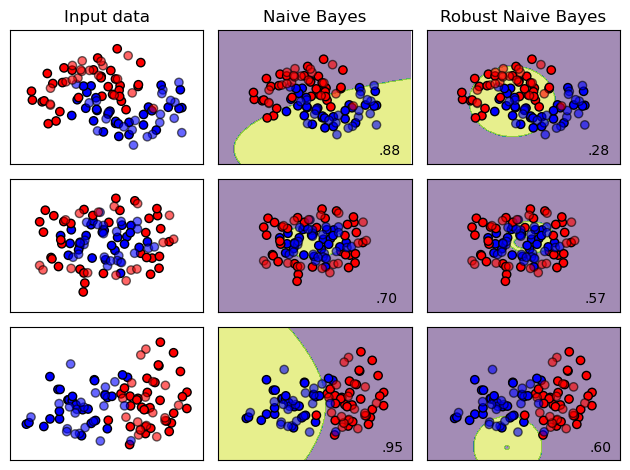

In [407]:
for ds_cnt, ds in enumerate(datasets):
    # preprocess dataset, split into training and test part
    X, y = ds
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5

    # just plot the dataset first
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(["#FF0000", "#0000FF"])
    ax = plt.subplot(len(datasets), len(classifiers) +1, i)
    if ds_cnt == 0:
        ax.set_title("Input data")
    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k")
    # Plot the testing points
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6, edgecolors="k")
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks(())
    ax.set_yticks(())
    i += 1

    # iterate over classifiers
    for name, clf in classifiers.items():
        ax = plt.subplot(len(datasets), len(classifiers) + 1, i)

        # Create a meshgrid for plotting
        h = .02  # Step size in the mesh
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

        

        #clf = make_pipeline(StandardScaler(), clf)
        clf.fit(X_train, y_train)

        # Make predictions using the classifier
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        plt.contourf(xx, yy, Z, alpha=.5)

        y_pred = clf.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        """ DecisionBoundaryDisplay.from_estimator(
            clf, X, cmap=cm, alpha=.8, ax=ax, eps=.5
        ) """
        
        # Plot the training points
        ax.scatter(
            X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k"
        )
        # Plot the testing points
        ax.scatter(
            X_test[:, 0],
            X_test[:, 1],
            c=y_test,
            cmap=cm_bright,
            edgecolors="k",
            alpha=0.6,
        )
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)
        ax.set_xticks(())
        ax.set_yticks(())
        if ds_cnt == 0:
            ax.set_title(name)
        ax.text(
            x_max - 0.3,
            y_min + 0.3,
            ("%.2f" % accuracy).lstrip("0"),
            size=10,
            horizontalalignment="right",
        )
        i += 1
plt.tight_layout()
plt.show()